### Introduction
Natural Language Processing (NLP): The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

Sentiment Analysis: It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a Sentiment Analysis model to categorize a tweet as Positive or Negative.

Table of Contents
Importing dependencies
Importing dataset
Preprocessing Text
Analysing data
Splitting data
TF-IDF Vectoriser
Transforming Dataset
Creating and Evaluating Models
BernoulliNB Model
LinearSVC Model
Logistic Regression Model
Saving the Models
Using the Model

### Importing Dependencies

In [1]:
import re
import os
import gensim
import numpy as np
import pandas as pd
import string
import random
import warnings
warnings.filterwarnings("ignore")
from collections import Counter


# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
from spacy.util import compounding
from spacy.util import minibatch


# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stop_words = stopwords.words('english')


# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


# Tensorflow and Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences





## Importing Dataset

The dataset being used is the sentiment140 which is publically available at Kaggle and is open-source. It is publiashed for the research purpose and used for different Kaggle competitions. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

It contains the following 6 fields:

sentiment: the polarity of the tweet (0 = negative, 4 = positive)
ids: The id of the tweet (2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)
We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

In [2]:
data = pd.read_csv('dataset.csv', encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

Five top records of data

In [3]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Five last rows of the dataset

In [4]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


Columns/features in the data

In [5]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

Length of the data

In [6]:
print("Length of the dataset is" , len(data))

Length of the dataset is 1599999


Shape of the data 

In [7]:
data.shape

(1599999, 6)

Data Information

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Data types of all the columns

In [9]:
data.dtypes

label        int64
time         int64
date        object
query       object
username    object
text        object
dtype: object

Checking Null values

In [10]:
np.sum(data.isnull().any(axis=1))

0

Rows and columns in the dataset

In [11]:
print('Count of columns in the data is:  ', len(data.columns))
print('Count of rows in the data is:  ', len(data))

Count of columns in the data is:   6
Count of rows in the data is:   1599999


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns. Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

In [12]:
data = data.sample(frac=1).reset_index(drop=True)


In [13]:
data = data.drop(['time', 'date', 'query', 'username'], axis=1)
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
data.label = data.label.apply(lambda x: label_decoder(x))
data.head()

,label,text
0,Positive,finally a nice day to grill
1,Negative,Sprinting down a rocky hill and having the gro...
2,Negative,20 mins from home and i owe john 3 shots cause...
3,Positive,@jasoncastro cool! have a great day!
4,Negative,My ankle hurts


## Preprocessing words

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

1. Lower Casing: Each text is converted to lowercase.
2. Removing URLs: Links starting with "http" or "https" or "www" are removed.
3. Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
4. Removing Usernames: Removing @Usernames with word "USER". (eg: "@Kaggle" to "USER")
5. Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
6. Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
7. Removing Short Words: Words with length less than 2 are removed.
8. Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
9. Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

Here are decoding the labels. We map 0 -> Negative and 1 -> Positive as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution.

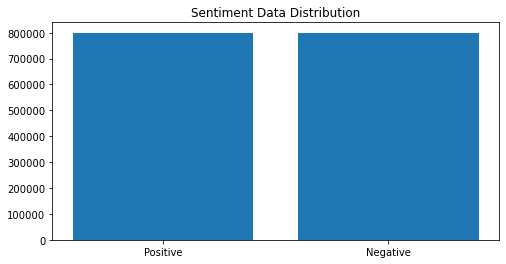

In [14]:
data = data.sample(frac=1).reset_index(drop=True)
val_count = data.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")
plt.show()

We can clearly see that the dataset is free from any skewness.Hence, we don't need to perform any imbalancing techniques.

In [15]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [16]:
# Defining the various patterns

urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z0-9]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"



In [17]:
def preprocess(textdata):
   
    # Create Lemmatizer and Stemmer.
    stemmer = SnowballStemmer('english')
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
        
    # Replace all URls with 'URL'
    textdata = re.sub(urlPattern,' ',str(textdata).lower()).strip()
    # Replace all emojis.
    for emoji in emojis.keys():
        textdata = textdata.replace(emoji, "EMOJI" + emojis[emoji])        
    # Replace @USERNAME to 'USER'.
    textdata = re.sub(userPattern,"", str(textdata).lower()).strip()
    # Replace all non alphabets.
    textdata = re.sub(alphaPattern, " ", str(textdata).lower()).strip()
    # Replace 3 or more consecutive letters by 2 letter.
    textdata = re.sub(sequencePattern, seqReplacePattern, str(textdata).lower()).strip()
    
    processedText = []
    for token in textdata.split():
        if token not in stop_words:
            processedText.append(stemmer.stem(token))
        
    return " ".join(processedText)
    


In [18]:
#Creating a new column named cleaned_text for the processed words

data['cleaned_text'] = data['text'].apply(lambda x: preprocess(x))

## EDA

Most Common words in our clean_text

In [19]:
data['temp_list'] = data['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list']  for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,go,138548
1,get,110758
2,day,106272
3,good,94163
4,work,87749
5,like,83837
6,love,83077
7,quot,71599
8,today,68705
9,time,66449


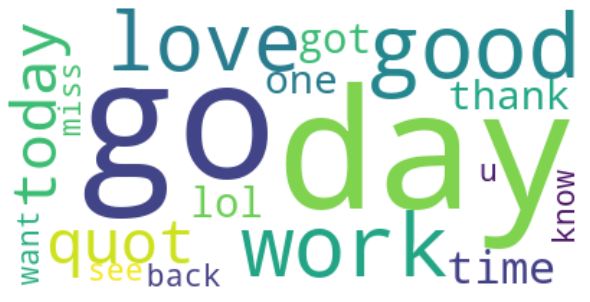

In [20]:
# Wordcloud for most common words 

# combine all text into a single string
text = ' '.join(temp['Common_words'].tolist())

# create wordcloud object and generate wordcloud
wordcloud = WordCloud(background_color='white', max_words=100).generate(text)

# plot the wordcloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


Most common words Sentiments Wise

In [21]:
positive_sent = data[data['label']=='Positive']
negative_sent = data[data['label']=='Negative']

In [22]:
#MosT common positive words
top = Counter([item for sublist in positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,64125
1,love,61226
2,go,59279
3,day,55802
4,thank,51059
5,get,49226
6,quot,45873
7,like,40572
8,lol,36240
9,time,34653


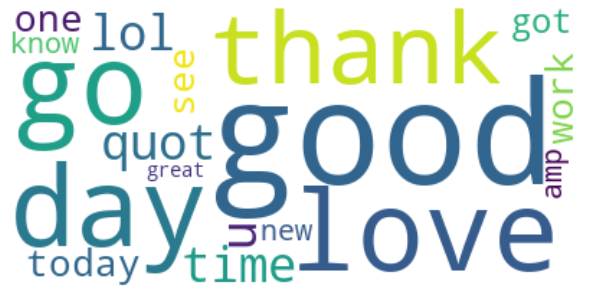

In [23]:
# Wordcloud for most common positive words 

# combine all text into a single string
text = ' '.join(temp_positive['Common_words'].tolist())

# create wordcloud object and generate wordcloud
wordcloud = WordCloud(background_color='white', max_words=100).generate(text)

# plot the wordcloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [24]:
#MosT common negative words
top = Counter([item for sublist in negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,61532
2,work,58971
3,day,50470
4,miss,47864
5,like,43265
6,want,40272
7,today,38365
8,feel,37044
9,got,33491
10,back,33354


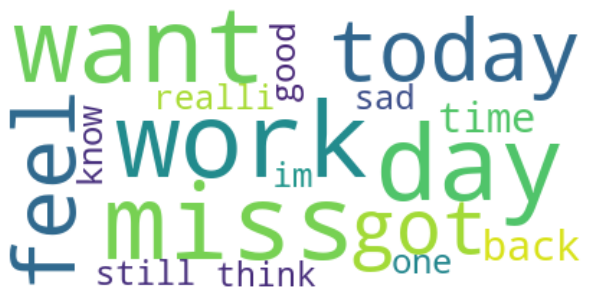

In [25]:
# Wordcloud for most common negative words 

# combine all text into a single string
text = ' '.join(temp_negative['Common_words'].tolist())

# create wordcloud object and generate wordcloud
wordcloud = WordCloud(background_color='white', max_words=100).generate(text)

# plot the wordcloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Data Modelling


#### Splitting the data




In [26]:

# Converting the values of label column back to binary form for easier analysis

lab_to_sentiment = {"Negative":0,"Positive":1}
def label_decoder(label):
  return lab_to_sentiment[label]
data.label = data.label.apply(lambda x: label_decoder(x))
data.head()

,label,text,cleaned_text,temp_list
0,1,@Shes_Wanderin so true! thanks for the remind...,true thank remind support hug,"[true, thank, remind, support, hug]"
1,0,@dgtlpapercuts I'm not sure if 1pm is correct...,sure 1pm correct appl websit say june 18th,"[sure, 1pm, correct, appl, websit, say, june, ..."
2,1,is resting and enjoying the peaceful weekend,rest enjoy peac weekend,"[rest, enjoy, peac, weekend]"
3,0,producing jailbreak video and then uploading i...,produc jailbreak video upload youtub tri uploa...,"[produc, jailbreak, video, upload, youtub, tri..."
4,1,@sevgisahin hi,hi,[hi]


The Preprocessed Data is divided into 2 sets of data:

Training Data: The dataset upon which the model would be trained on. Contains 80% data.
Test Data: The dataset upon which the model would be tested against. Contains 20% data.
    
    


In [28]:

x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'][:100000], data['label'][:100000], test_size=0.3, random_state=42)
print("X_train",x_train.shape)
print("y_train",y_train.shape)
print("X_test",x_test.shape)
print("y_train",y_test.shape)

X_train (70000,)
y_train (70000,)
X_test (30000,)
y_train (30000,)


#### One hot encoding 

One-hot encoding is a popular technique used in machine learning and natural language processing to represent categorical variables as binary vectors. In one-hot encoding, each unique value in a categorical variable is represented as a binary vector with a length equal to the number of unique values in the variable. The vector has a value of 1 in the position corresponding to the unique value of the categorical variable, and 0 in all other positions. This technique allows machine learning algorithms to interpret categorical variables as continuous variables and effectively handle them in their mathematical computations. One-hot encoding is commonly used in tasks such as text classification, sentiment analysis, and image recognition.

In [29]:

# Concatenate the training and testing data
all_data = pd.concat([x_train, x_test])

# Fit the OneHotEncoder on the concatenated data
encoder = OneHotEncoder()
encoder.fit(all_data.to_numpy().reshape(-1, 1))

# Transform the training and test data separately
X_train_encoded = encoder.transform(x_train.to_numpy().reshape(-1, 1))
X_test_encoded = encoder.transform(x_test.to_numpy().reshape(-1, 1))



##### Logistic regression

In [30]:

# Create an instance of the LogisticRegression model
log_model = LogisticRegression(solver = 'saga',random_state = 42,max_iter = 1000, n_jobs = -1)

# Train the model on the training data
log_model.fit(X_train_encoded, y_train)

# Predicting the values of x_train
y_pred = log_model.predict(X_test_encoded)

In [32]:
def print_train_metrics(model, X_train, y_train):
    # Make predictions on the training data
    y_train_pred = model.predict(X_train)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_train, y_train_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate accuracy, sensitivity, specificity, and F1 score
    accuracy = accuracy_score(y_train, y_train_pred)
    sensitivity = recall_score(y_train, y_train_pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    f1 = f1_score(y_train, y_train_pred)
    print("Accuracy:", accuracy)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("F1 Score:", f1)

    # Calculate ROC score
    roc_score = roc_auc_score(y_train, y_train_pred)
    print("ROC Score:", roc_score)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    plt.plot(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


##### Logistic Model evaluation 

In [33]:

# Evaluate the model on the train data
score = log_model.score(X_train_encoded, y_train)
print("Train accuracy: {:.2f}%".format(score * 100))
# Evaluate the model on the test data
score = log_model.score(X_test_encoded, y_test)
print("Test accuracy: {:.2f}%".format(score * 100))



# Creating a funtion for getting the various metrics

def print_metrics(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate accuracy, sensitivity, specificity, and F1 score
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    f1 = f1_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("F1 Score:", f1)

    # Calculate ROC score
    roc_score = roc_auc_score(y_true, y_pred)
    print("ROC Score:", roc_score)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


Train accuracy: 99.36%
Test accuracy: 51.81%


Confusion Matrix:
[[34883   261]
 [  190 34666]]
Accuracy: 0.9935571428571428
Sensitivity: 0.9945490016066101
Specificity: 0.9925734122467562
F1 Score: 0.9935371078916069
ROC Score: 0.9935612069266831


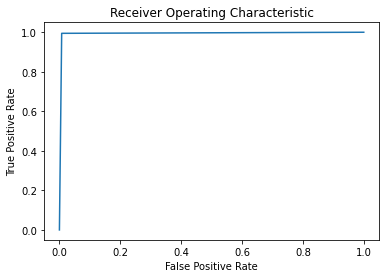

In [35]:
print_train_metrics(log_model, X_train_encoded, y_train)

Confusion Matrix:
[[14779   171]
 [14286   764]]
Accuracy: 0.5181
Sensitivity: 0.05076411960132891
Specificity: 0.988561872909699
F1 Score: 0.0955896152643103
ROC Score: 0.5196629962555139


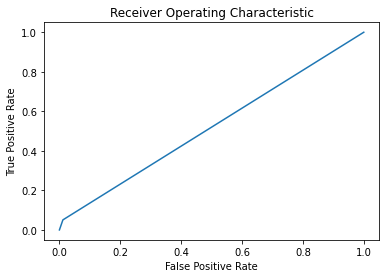

In [38]:
print_metrics(y_test,y_pred)


##### Logistic Regression with Hyperparameter tuning


In [39]:
'''Hyperparameter tuning'''
prototype = LogisticRegression(max_iter = 1000,solver = 'saga', n_jobs = -1)

parameters = [{ 'C': [0.1,0.5,1,2,5]}]

# Cross-validation
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

prototype_cv = GridSearchCV(estimator=prototype, 
                         param_grid =parameters,
                         scoring= 'roc_auc',
                         cv=folds, 
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=1)

prototype_cv.fit(X_train_encoded, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                          solver='saga'),
             n_jobs=-1, param_grid=[{'C': [0.1, 0.5, 1, 2, 5]}],
             return_train_score=True, scoring='roc_auc', verbose=1)

In [40]:
# Best params are 

print("Best hyperparameter: ", prototype_cv.best_params_)

Best hyperparameter:  {'C': 5}


##### Logistic Model with hyperparameter evaluation 

In [41]:

# Create an instance of the LogisticRegression model
log_hypemodel = LogisticRegression(random_state = 1000,C = 5,n_jobs=-1,max_iter = 1000)

# Train the model on the training data
log_hypemodel.fit(X_train_encoded, y_train)

# Predicting the values of x_train
y_pred = log_hypemodel.predict(X_test_encoded)



Confusion Matrix:
[[34883   261]
 [  190 34666]]
Accuracy: 0.9935571428571428
Sensitivity: 0.9945490016066101
Specificity: 0.9925734122467562
F1 Score: 0.9935371078916069
ROC Score: 0.9935612069266831


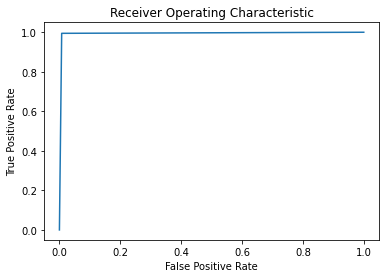

In [42]:
print_train_metrics(log_hypemodel, X_train_encoded, y_train)

Confusion Matrix:
[[14779   171]
 [14286   764]]
Accuracy: 0.5181
Sensitivity: 0.05076411960132891
Specificity: 0.988561872909699
F1 Score: 0.0955896152643103
ROC Score: 0.5196629962555139


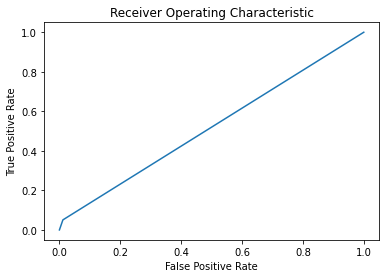

In [43]:

print_metrics(y_test,y_pred)

##### Decision Treee Classifier 

In [44]:

# Create an instance of the Decision tree  model
tree = DecisionTreeClassifier(random_state = 100, max_features='sqrt')

# Train the model on the training data
tree.fit(X_train_encoded, y_train)

# Predicting the values of x_train
y_treepred = tree.predict(X_test_encoded)

Confusion Matrix:
[[34883   261]
 [  190 34666]]
Accuracy: 0.9935571428571428
Sensitivity: 0.9945490016066101
Specificity: 0.9925734122467562
F1 Score: 0.9935371078916069
ROC Score: 0.9935612069266831


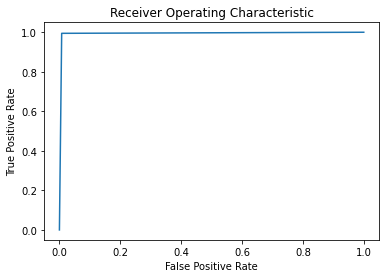

In [46]:
print_train_metrics(tree, X_train_encoded, y_train)

Confusion Matrix:
[[14779   171]
 [14286   764]]
Accuracy: 0.5181
Sensitivity: 0.05076411960132891
Specificity: 0.988561872909699
F1 Score: 0.0955896152643103
ROC Score: 0.5196629962555139


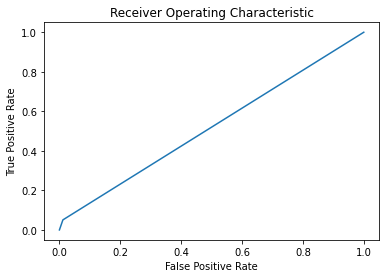

In [45]:
print_metrics(y_test,y_treepred)

##### Decision tree with hyperparameter 


In [47]:
# Choosing the hyperparameters

parameters = {
    'min_samples_leaf' : range(50,500,50),
    'min_samples_split' : range(50,500,50),
    'max_depth' : range(5,15,5)
   
}


# Instanciating Decision Tree

tree = DecisionTreeClassifier(random_state = 42,max_features='sqrt')

#Instanciating Grid search CV

model_tree = GridSearchCV(estimator = tree,
                         param_grid = parameters,
                         scoring= 'roc_auc',
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         )

# Fitting the model on the data

model_tree.fit(X_train_encoded,y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_features='sqrt',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 500, 50),
                         'min_samples_split': range(50, 500, 50)},
             scoring='roc_auc', verbose=1)

In [48]:
model_tree.best_params_

{'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 50}

In [49]:

# Create an instance of the LogisticRegression model
hyper_tree = DecisionTreeClassifier(min_samples_split = 50, min_samples_leaf = 50, max_depth = 5,random_state = 49)

# Train the model on the training data
hyper_tree.fit(X_train_encoded, y_train)

# Predicting the values of x_train
y_hypepred = hyper_tree.predict(X_test_encoded)

Confusion Matrix:
[[34989   155]
 [34393   463]]
Accuracy: 0.5064571428571428
Sensitivity: 0.01328322240073445
Specificity: 0.9955895743227863
F1 Score: 0.026103625190280207
ROC Score: 0.5044363983617604


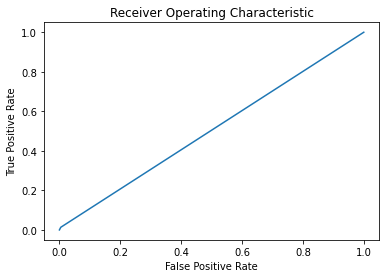

In [50]:
print_train_metrics(hyper_tree, X_train_encoded, y_train)

Confusion Matrix:
[[14865    85]
 [14841   209]]
Accuracy: 0.5024666666666666
Sensitivity: 0.01388704318936877
Specificity: 0.994314381270903
F1 Score: 0.027241918665276334
ROC Score: 0.5041007122301359


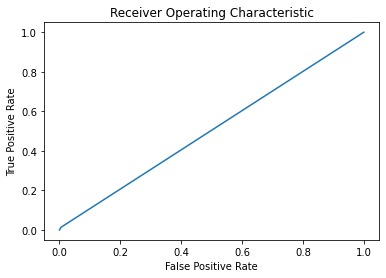

In [51]:

print_metrics(y_test,y_hypepred)

##### XGBoost

In [52]:
# Create an instance of the XGBoos
boosted_tree = XGBClassifier(random_state = 50)

# Train the model on the training data
boosted_tree.fit(X_train_encoded, y_train)

# Predicting the values of x_train
y_boosted = boosted_tree.predict(X_test_encoded)


[06:55:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix:
[[34945   199]
 [33871   985]]
Accuracy: 0.5132857142857142
Sensitivity: 0.028259123249942623
Specificity: 0.9943375825176417
F1 Score: 0.054661487236404
ROC Score: 0.5112983528837922


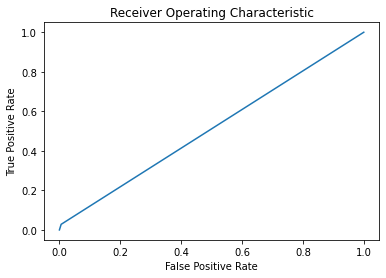

In [53]:
print_train_metrics(boosted_tree, X_train_encoded, y_train)

Confusion Matrix:
[[14837   113]
 [14640   410]]
Accuracy: 0.5082333333333333
Sensitivity: 0.02724252491694352
Specificity: 0.9924414715719063
F1 Score: 0.052655236627496306
ROC Score: 0.5098419982444249


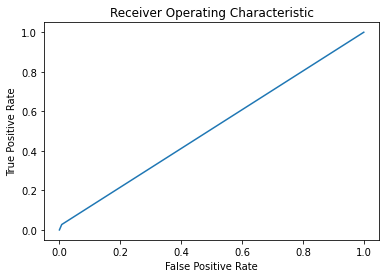

In [54]:
print_metrics(y_test,y_boosted)

##### XGBoost with hyperparameters



In [55]:
# Chosing the hyperparameters

parameters = {
    'subsample': [0.3, 0.6, 0.9],
    'learning_rate': [0.2, 0.6],
                                }

# Instanciating XGBoost model

xgboost = XGBClassifier(max_depth=2, n_estimators=200)

#Instanciating Grid search CV

xgboost_overmodel = GridSearchCV(estimator = xgboost,
                         param_grid = parameters,
                         scoring= 'roc_auc',
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         return_train_score = True)

# Fitting the model on the data

xgboost_overmodel.fit(X_train_encoded,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[06:56:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [56]:
xgboost_overmodel.best_params_

{'learning_rate': 0.6, 'subsample': 0.9}

In [57]:
# Create an instance of the LogisticRegression model
boosted_hyper = XGBClassifier(learning_rate = 0.6, subsample = 0.9)

# Train the model on the training data
boosted_hyper.fit(X_train_encoded, y_train)

# Predicting the values of x_test
y_boost = boosted_hyper.predict(X_test_encoded)

[06:56:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix:
[[34907   237]
 [33818  1038]]
Accuracy: 0.5135
Sensitivity: 0.029779664907046133
Specificity: 0.9932563168677442
F1 Score: 0.05745758489939388
ROC Score: 0.5115179908873951


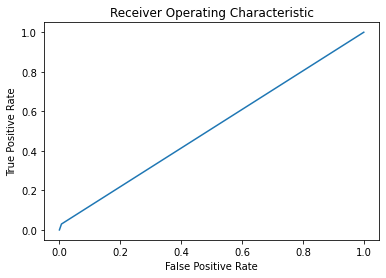

In [58]:
print_train_metrics(boosted_hyper, X_train_encoded, y_train)

Confusion Matrix:
[[14822   128]
 [14620   430]]
Accuracy: 0.5084
Sensitivity: 0.02857142857142857
Specificity: 0.991438127090301
F1 Score: 0.055099948744233726
ROC Score: 0.5100047778308647


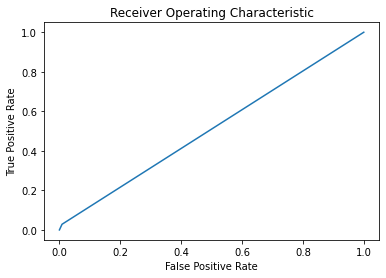

In [59]:
print_metrics(y_test,y_boost)

##### Naive Bayes

In [60]:
# Create an instance of the Naive Bayes

naive_bayes = ComplementNB()

# Train the model on the training data
naive_bayes.fit(X_train_encoded, y_train)

# Predicting the values of x_train
y_pred_naive = naive_bayes.predict(X_test_encoded)

Confusion Matrix:
[[34792   352]
 [   99 34757]]
Accuracy: 0.9935571428571428
Sensitivity: 0.9971597429423915
Specificity: 0.9899840655588437
F1 Score: 0.9935539198170514
ROC Score: 0.9935719042506176


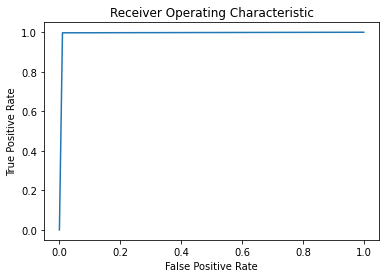

In [61]:
print_train_metrics(naive_bayes, X_train_encoded, y_train)

Confusion Matrix:
[[  507 14443]
 [   73 14977]]
Accuracy: 0.5161333333333333
Sensitivity: 0.9951495016611296
Specificity: 0.03391304347826087
F1 Score: 0.6735776928266246
ROC Score: 0.5145312725696952


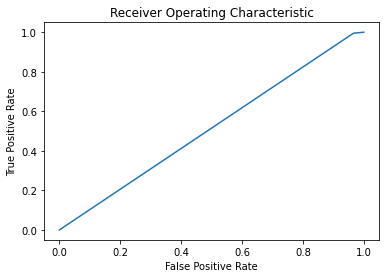

In [62]:
print_metrics(y_test,y_pred_naive)

##### Naive Bayes with Hyperparameter tuning 

In [63]:


# Chosing the hyperparameters

parameters = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'norm': [True, False],
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]
}



# Instanciating Naive bayes

naive_hype = ComplementNB()

#Instanciating Grid search CV

naive_model = GridSearchCV(estimator = naive_hype,
                         param_grid = parameters,
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         return_train_score = True)

# Fitting the model on the data

naive_model.fit(X_train_encoded,y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0],
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8],
                                         [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
                         'norm': [True, False]},
             return_train_score=True, verbose=1)

In [64]:
naive_model.best_params_

{'alpha': 0.1, 'class_prior': None, 'norm': True}

In [65]:
# Create an instance of the Naive bayes model

hyper_naive = ComplementNB(alpha = 0.1, class_prior = None, norm = True)

# Train the model on the training data
hyper_naive.fit(X_train_encoded, y_train)

# Predicting the values of x_train
y_naive_pred = hyper_naive.predict(X_test_encoded)

Confusion Matrix:
[[34792   352]
 [   99 34757]]
Accuracy: 0.9935571428571428
Sensitivity: 0.9971597429423915
Specificity: 0.9899840655588437
F1 Score: 0.9935539198170514
ROC Score: 0.9935719042506176


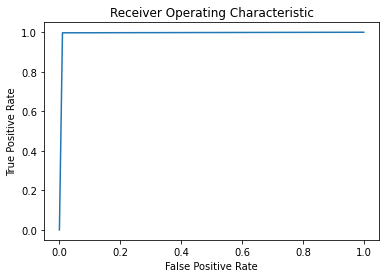

In [66]:
print_train_metrics(hyper_naive, X_train_encoded, y_train)

Confusion Matrix:
[[  507 14443]
 [   73 14977]]
Accuracy: 0.5161333333333333
Sensitivity: 0.9951495016611296
Specificity: 0.03391304347826087
F1 Score: 0.6735776928266246
ROC Score: 0.5145312725696952


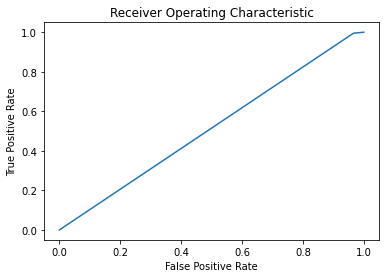

In [67]:
print_metrics(y_test,y_naive_pred)


#### Bag of Words

Bag of Words (BoW) is a method in natural language processing (NLP) that is used to represent a text document as a collection of words, ignoring their order but counting their frequency. The resulting representation is called a "bag" because the order of words is not taken into account, and the frequency of each word is treated as an independent feature.

In [68]:
# Concatenate the training and testing data
all_data = pd.concat([x_train, x_test])

# Fit the Count Vectorizer on the concatenated data
vectorizer = CountVectorizer()
vectorizer.fit(all_data)

# Transform the training and test data separately
X_train_vectorizer = vectorizer.transform(x_train)
X_test_vectorizer = vectorizer.transform(x_test)




##### Logistic regression

In [69]:

# Create an instance of the LogisticRegression model
log_model = LogisticRegression(solver = 'saga',random_state = 42,max_iter = 1000, n_jobs = -1)

# Train the model on the training data
log_model.fit(X_train_vectorizer, y_train)

# Predicting the values of x_train
y_pred = log_model.predict(X_test_vectorizer)


Confusion Matrix:
[[28971  6173]
 [ 5174 29682]]
Accuracy: 0.8379
Sensitivity: 0.8515607069084232
Specificity: 0.8243512406100615
F1 Score: 0.8395299175517246
ROC Score: 0.8379559737592424


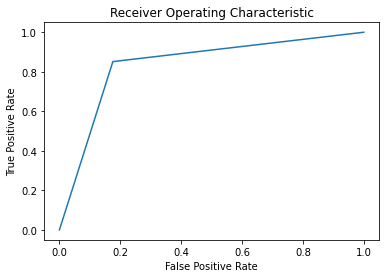

In [70]:
print_train_metrics(log_model, X_train_vectorizer, y_train)

Confusion Matrix:
[[11032  3918]
 [ 3454 11596]]
Accuracy: 0.7542666666666666
Sensitivity: 0.7704983388704318
Specificity: 0.7379264214046822
F1 Score: 0.758801204030886
ROC Score: 0.7542123801375571


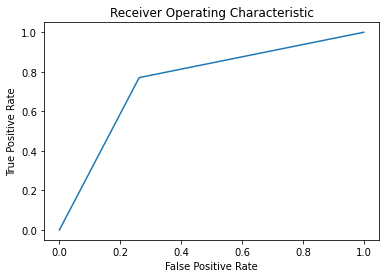

In [71]:
print_metrics(y_test,y_pred)


##### Logistic Regression with Hyperparameter tuning


In [72]:
'''Hyperparameter tuning'''
prototype = LogisticRegression(max_iter = 1000,solver = 'saga', n_jobs = -1)

parameters = [{ 'C': [0.1,0.5,1,2,5]}]

# Cross-validation
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

prototype_cv = GridSearchCV(estimator=prototype, 
                         param_grid =parameters,
                         scoring= 'roc_auc',
                         cv=folds, 
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=1)

prototype_cv.fit(X_train_vectorizer, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                          solver='saga'),
             n_jobs=-1, param_grid=[{'C': [0.1, 0.5, 1, 2, 5]}],
             return_train_score=True, scoring='roc_auc', verbose=1)

In [73]:
print("Best hyperparameter: ", prototype_cv.best_params_)

Best hyperparameter:  {'C': 0.1}


In [76]:

# Create an instance of the LogisticRegression model
log_hypemodel = LogisticRegression(random_state = 1000,C = 0.1,n_jobs=-1,max_iter = 1000)

# Train the model on the training data
log_hypemodel.fit(X_train_vectorizer, y_train)

# Predicting the values of x_train
y_pred = log_hypemodel.predict(X_test_vectorizer)



Confusion Matrix:
[[26887  8257]
 [ 6484 28372]]
Accuracy: 0.7894142857142857
Sensitivity: 0.813977507459261
Specificity: 0.7650523560209425
F1 Score: 0.7937889067636568
ROC Score: 0.7895149317401016


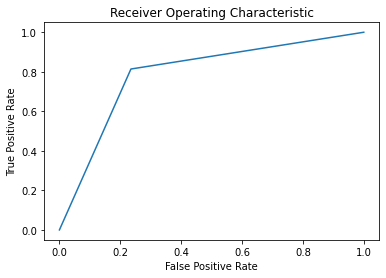

In [77]:
print_train_metrics(log_hypemodel, X_train_vectorizer, y_train)

Confusion Matrix:
[[10939  4011]
 [ 3303 11747]]
Accuracy: 0.7562
Sensitivity: 0.780531561461794
Specificity: 0.7317056856187291
F1 Score: 0.762594131394443
ROC Score: 0.7561186235402616


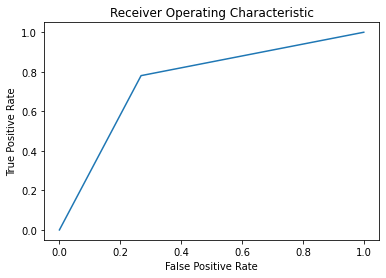

In [78]:
print_metrics(y_test,y_pred)

##### Decision Treee Classifier 

In [79]:

# Create an instance of the Decision tree  model
tree = DecisionTreeClassifier(random_state = 100, max_features='sqrt')

# Train the model on the training data
tree.fit(X_train_vectorizer, y_train)

# Predicting the values of x_train
y_treepred = tree.predict(X_test_vectorizer)

Confusion Matrix:
[[34876   268]
 [  211 34645]]
Accuracy: 0.9931571428571428
Sensitivity: 0.9939465228368143
Specificity: 0.9923742317323014
F1 Score: 0.9931344866631312
ROC Score: 0.9931603772845579


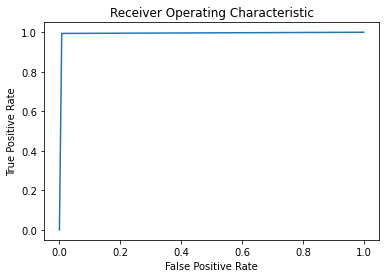

In [80]:
print_train_metrics(tree, X_train_vectorizer, y_train)

Confusion Matrix:
[[9996 4954]
 [5248 9802]]
Accuracy: 0.6599333333333334
Sensitivity: 0.651295681063123
Specificity: 0.668628762541806
F1 Score: 0.6577199221633229
ROC Score: 0.6599622218024646


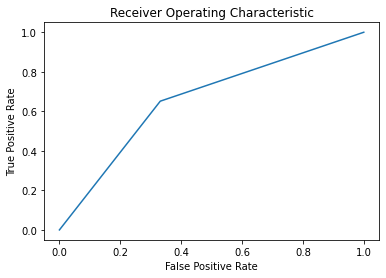

In [81]:
print_metrics(y_test,y_treepred)

##### Decision tree with hyperparameter 


In [82]:
# Choosing the hyperparameters

parameters = {
    'min_samples_leaf' : range(50,500,50),
    'min_samples_split' : range(50,500,50),
    'max_depth' : range(5,15,5)
   
}


# Instanciating Decision Tree

tree = DecisionTreeClassifier(random_state = 42,max_features='sqrt')

#Instanciating Grid search CV

model_tree = GridSearchCV(estimator = tree,
                         param_grid = parameters,
                         scoring= 'roc_auc',
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         )

# Fitting the model on the data

model_tree.fit(X_train_vectorizer,y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_features='sqrt',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 500, 50),
                         'min_samples_split': range(50, 500, 50)},
             scoring='roc_auc', verbose=1)

In [83]:
model_tree.best_params_

{'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 50}

In [84]:

# Create an instance of the LogisticRegression model
hyper_tree = DecisionTreeClassifier(min_samples_split = 50, min_samples_leaf = 50, max_depth = 10,random_state = 49)

# Train the model on the training data
hyper_tree.fit(X_train_vectorizer, y_train)

# Predicting the values of x_train
y_hypepred = hyper_tree.predict(X_test_vectorizer)

Confusion Matrix:
[[ 9034 26110]
 [ 2315 32541]]
Accuracy: 0.5939285714285715
Sensitivity: 0.9335838879963277
Specificity: 0.257056681083542
F1 Score: 0.6960120632679906
ROC Score: 0.5953202845399348


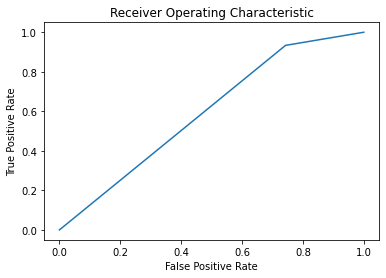

In [85]:
print_train_metrics(hyper_tree, X_train_vectorizer, y_train)

Confusion Matrix:
[[ 3840 11110]
 [ 1015 14035]]
Accuracy: 0.5958333333333333
Sensitivity: 0.9325581395348838
Specificity: 0.2568561872909699
F1 Score: 0.6983455653688271
ROC Score: 0.5947071634129268


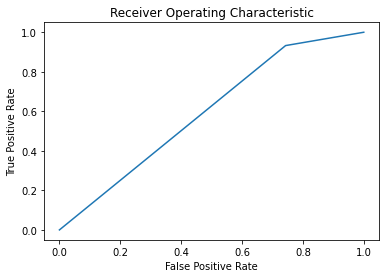

In [86]:

print_metrics(y_test,y_hypepred)

##### XGBoost

In [87]:
# Create an instance of the XGBoos
boosted_tree = XGBClassifier(random_state = 50)

# Train the model on the training data
boosted_tree.fit(X_train_vectorizer, y_train)

# Predicting the values of x_train
y_boosted = boosted_tree.predict(X_test_vectorizer)


[07:05:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix:
[[23716 11428]
 [ 5616 29240]]
Accuracy: 0.7565142857142857
Sensitivity: 0.8388799632774845
Specificity: 0.6748235829729115
F1 Score: 0.7743233938880356
ROC Score: 0.756851773125198


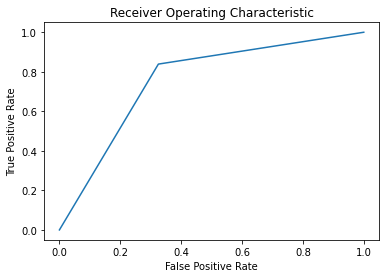

In [88]:
print_train_metrics(boosted_tree, X_train_vectorizer, y_train)

Confusion Matrix:
[[ 9788  5162]
 [ 2825 12225]]
Accuracy: 0.7337666666666667
Sensitivity: 0.8122923588039868
Specificity: 0.6547157190635452
F1 Score: 0.7537688442211056
ROC Score: 0.7335040389337659


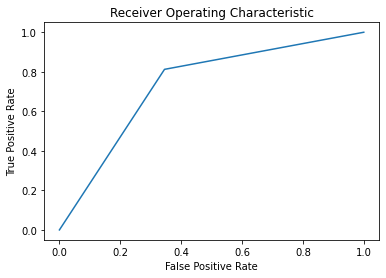

In [89]:
print_metrics(y_test,y_boosted)

##### XGBoost with hyperparameters



In [90]:
# Chosing the hyperparameters

parameters = {
    'subsample': [0.3, 0.6, 0.9],
    'learning_rate': [0.2, 0.6],
                                }

# Instanciating XGBoost model

xgboost = XGBClassifier(max_depth=2, n_estimators=200)

#Instanciating Grid search CV

xgboost_overmodel = GridSearchCV(estimator = xgboost,
                         param_grid = parameters,
                         scoring= 'roc_auc',
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         return_train_score = True)

# Fitting the model on the data

xgboost_overmodel.fit(X_train_vectorizer,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[07:06:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [91]:
xgboost_overmodel.best_params_

{'learning_rate': 0.6, 'subsample': 0.9}

In [92]:
# Create an instance of the LogisticRegression model
boosted_hyper = XGBClassifier(learning_rate = 0.6, subsample = 0.9)

# Train the model on the training data
boosted_hyper.fit(X_train_vectorizer, y_train)

# Predicting the values of x_test
y_boost = boosted_hyper.predict(X_test_vectorizer)

[07:06:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix:
[[25461  9683]
 [ 6065 28791]]
Accuracy: 0.7750285714285714
Sensitivity: 0.8259983933899472
Specificity: 0.724476439790576
F1 Score: 0.7852447838538115
ROC Score: 0.7752374165902615


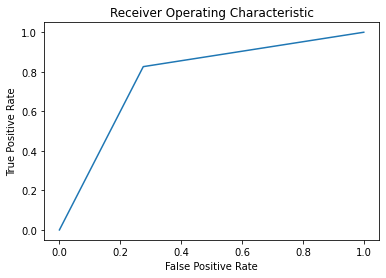

In [93]:
print_train_metrics(boosted_hyper, X_train_vectorizer, y_train)

Confusion Matrix:
[[10371  4579]
 [ 3092 11958]]
Accuracy: 0.7443
Sensitivity: 0.7945514950166113
Specificity: 0.6937123745819398
F1 Score: 0.7571469275334789
ROC Score: 0.7441319347992755


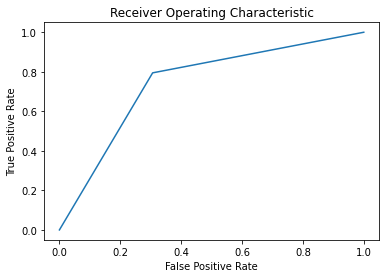

In [94]:
print_metrics(y_test,y_boost)

##### Naive Bayes

In [95]:
# Create an instance of the Naive Bayes

naive_bayes = ComplementNB()

# Train the model on the training data
naive_bayes.fit(X_train_vectorizer, y_train)

# Predicting the values of x_train
y_pred_naive = naive_bayes.predict(X_test_vectorizer)

Confusion Matrix:
[[29504  5640]
 [ 6972 27884]]
Accuracy: 0.8198285714285715
Sensitivity: 0.7999770484278172
Specificity: 0.8395174140678352
F1 Score: 0.8155601052939455
ROC Score: 0.8197472312478262


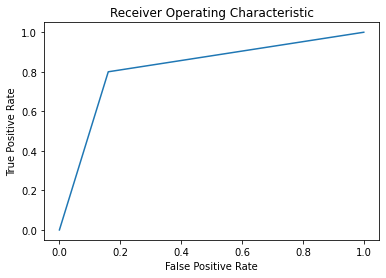

In [96]:
print_train_metrics(naive_bayes, X_train_vectorizer, y_train)

Confusion Matrix:
[[11536  3414]
 [ 4162 10888]]
Accuracy: 0.7474666666666666
Sensitivity: 0.7234551495016611
Specificity: 0.7716387959866221
F1 Score: 0.7418915235759062
ROC Score: 0.7475469727441416


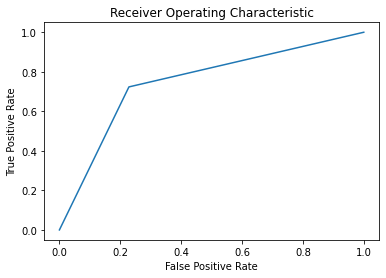

In [98]:
print_metrics(y_test,y_pred_naive)

##### Naive Bayes with Hyperparameter tuning 

In [99]:


# Chosing the hyperparameters

parameters = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'norm': [True, False],
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]
}



# Instanciating Naive bayes

naive_hype = ComplementNB()

#Instanciating Grid search CV

naive_model = GridSearchCV(estimator = naive_hype,
                         param_grid = parameters,
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         return_train_score = True)

# Fitting the model on the data

naive_model.fit(X_train_vectorizer,y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0],
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8],
                                         [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
                         'norm': [True, False]},
             return_train_score=True, verbose=1)

In [100]:
naive_model.best_params_

{'alpha': 2.0, 'class_prior': None, 'norm': False}

In [101]:
# Create an instance of the Naive bayes model

hyper_naive = ComplementNB(alpha = 2, class_prior = None, norm = False)

# Train the model on the training data
hyper_naive.fit(X_train_vectorizer, y_train)

# Predicting the values of x_train
y_naive_pred = hyper_naive.predict(X_test_vectorizer)

Confusion Matrix:
[[29286  5858]
 [ 7520 27336]]
Accuracy: 0.8088857142857143
Sensitivity: 0.7842552214826716
Specificity: 0.8333143637605281
F1 Score: 0.803409257898604
ROC Score: 0.8087847926215999


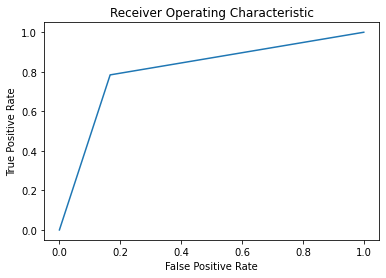

In [102]:
print_train_metrics(hyper_naive, X_train_vectorizer, y_train)

Confusion Matrix:
[[11668  3282]
 [ 4207 10843]]
Accuracy: 0.7503666666666666
Sensitivity: 0.7204651162790697
Specificity: 0.7804682274247492
F1 Score: 0.7433076263924593
ROC Score: 0.7504666718519095


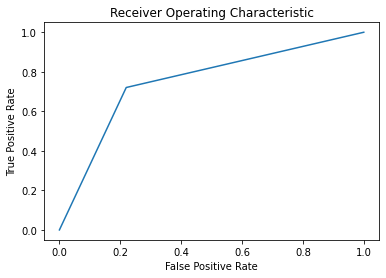

In [103]:
print_metrics(y_test,y_naive_pred)

#### TF - IDF

The intuition behind TF-IDF is as follows: if a word w appears many times in a sentence S1 but does not occur much in the rest of the Sentences Sn in the corpus, then the word w must be of great importance to the Sentence S1. The importance of w should increase in proportion to its frequency in S1 (how many times that word occurs in sentence S1), but at the same time, its importance should decrease in proportion to the word’s frequency in other Sentence Sn in the corpus. Mathematically, this is captured using two quantities: TF and IDF. The two are then multiplied to arrive at the TF-IDF score.

In [104]:

# Concatenate the training and testing data
all_data = pd.concat([x_train, x_test])

# Fit the TF-IDF on the concatenated data
tfidf = TfidfVectorizer()
tfidf.fit(all_data)

# Transform the training and test data separately
X_train_tfidf = tfidf.transform(x_train)
X_test_tfidf = tfidf.transform(x_test)



In [105]:
129

129

##### Logistic regression

In [106]:

# Create an instance of the LogisticRegression model
log_model = LogisticRegression(solver = 'saga',random_state = 42,max_iter = 1000, n_jobs = -1)

# Train the model on the training data
log_model.fit(X_train_tfidf, y_train)

# Predicting the values of x_train
y_pred = log_model.predict(X_test_tfidf)



Confusion Matrix:
[[28113  7031]
 [ 6018 28838]]
Accuracy: 0.8135857142857142
Sensitivity: 0.8273467982556805
Specificity: 0.7999374004097428
F1 Score: 0.8154966419229411
ROC Score: 0.8136420993327118


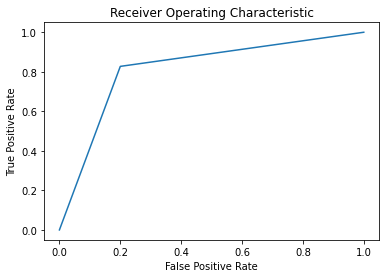

In [107]:
print_train_metrics(log_model, X_train_tfidf, y_train)

Confusion Matrix:
[[11048  3902]
 [ 3371 11679]]
Accuracy: 0.7575666666666667
Sensitivity: 0.7760132890365449
Specificity: 0.7389966555183947
F1 Score: 0.762560804413829
ROC Score: 0.7575049722774697


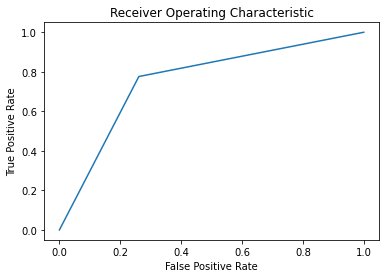

In [108]:
print_metrics(y_test,y_pred)


##### Logistic Regression with Hyperparameter tuning


In [109]:
'''Hyperparameter tuning'''
prototype = LogisticRegression(max_iter = 1000,solver = 'saga', n_jobs = -1)

parameters = [{ 'C': [0.1,0.5,1,2,5]}]

# Cross-validation
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

prototype_cv = GridSearchCV(estimator=prototype, 
                         param_grid =parameters,
                         scoring= 'roc_auc',
                         cv=folds, 
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=1)

prototype_cv.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                          solver='saga'),
             n_jobs=-1, param_grid=[{'C': [0.1, 0.5, 1, 2, 5]}],
             return_train_score=True, scoring='roc_auc', verbose=1)

In [110]:
# Best params are 

print("Best hyperparameter: ", prototype_cv.best_params_)

Best hyperparameter:  {'C': 1}


##### Logistic Model with hyperparameter evaluation 

In [111]:

# Create an instance of the LogisticRegression model
log_hypemodel = LogisticRegression(random_state = 1000,C = 1,n_jobs=-1,max_iter = 1000)

# Train the model on the training data
log_hypemodel.fit(X_train_tfidf, y_train)

# Predicting the values of x_train
y_pred = log_hypemodel.predict(X_test_tfidf)



Confusion Matrix:
[[28113  7031]
 [ 6021 28835]]
Accuracy: 0.8135428571428571
Sensitivity: 0.8272607298599954
Specificity: 0.7999374004097428
F1 Score: 0.8154463957467267
ROC Score: 0.8135990651348691


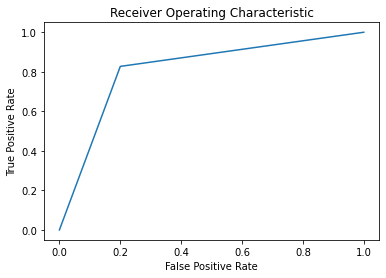

In [112]:
print_train_metrics(log_hypemodel, X_train_tfidf, y_train)

Confusion Matrix:
[[11048  3902]
 [ 3370 11680]]
Accuracy: 0.7576
Sensitivity: 0.7760797342192691
Specificity: 0.7389966555183947
F1 Score: 0.7626012013580569
ROC Score: 0.7575381948688319


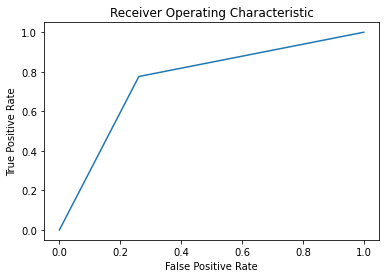

In [113]:
print_metrics(y_test,y_pred)

##### Decision Treee Classifier 

In [114]:

# Create an instance of the Decision tree  model
tree = DecisionTreeClassifier(random_state = 100, max_features='sqrt')

# Train the model on the training data
tree.fit(X_train_tfidf, y_train)

# Predicting the values of x_train
y_treepred = tree.predict(X_test_tfidf)

Confusion Matrix:
[[34871   273]
 [  214 34642]]
Accuracy: 0.9930428571428571
Sensitivity: 0.9938604544411292
Specificity: 0.9922319599362622
F1 Score: 0.9930200226455117
ROC Score: 0.9930462071886959


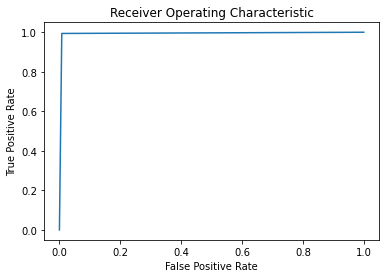

In [115]:
print_train_metrics(tree, X_train_tfidf, y_train)

Confusion Matrix:
[[ 9735  5215]
 [ 4998 10052]]
Accuracy: 0.6595666666666666
Sensitivity: 0.6679069767441861
Specificity: 0.6511705685618729
F1 Score: 0.6631262987762643
ROC Score: 0.6595387726530295


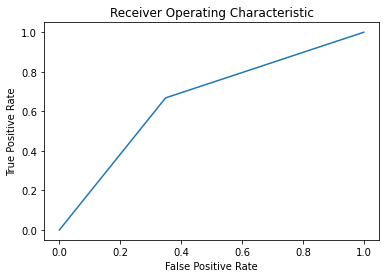

In [116]:
print_metrics(y_test,y_treepred)

##### Decision tree with hyperparameter 


In [117]:
# Choosing the hyperparameters

parameters = {
    'min_samples_leaf' : range(50,500,50),
    'min_samples_split' : range(50,500,50),
    'max_depth' : range(5,15,5)
   
}


# Instanciating Decision Tree

tree = DecisionTreeClassifier(random_state = 42,max_features='sqrt')

#Instanciating Grid search CV

model_tree = GridSearchCV(estimator = tree,
                         param_grid = parameters,
                         scoring= 'roc_auc',
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         )

# Fitting the model on the data

model_tree.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_features='sqrt',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 500, 50),
                         'min_samples_split': range(50, 500, 50)},
             scoring='roc_auc', verbose=1)

In [118]:
model_tree.best_params_

{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50}

In [119]:

# Create an instance of the LogisticRegression model
hyper_tree = DecisionTreeClassifier(min_samples_split = 50, min_samples_leaf = 50, max_depth = 10,random_state = 49)

# Train the model on the training data
hyper_tree.fit(X_train_tfidf, y_train)

# Predicting the values of x_train
y_hypepred = hyper_tree.predict(X_test_tfidf)

Confusion Matrix:
[[ 8992 26152]
 [ 2293 32563]]
Accuracy: 0.5936428571428571
Sensitivity: 0.9342150562313518
Specificity: 0.25586159799681313
F1 Score: 0.69600624124996
ROC Score: 0.5950383271140824


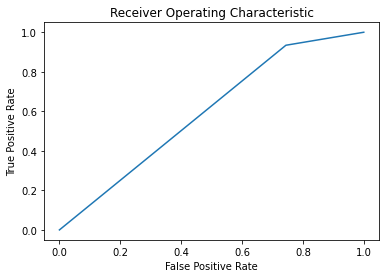

In [120]:
print_train_metrics(hyper_tree, X_train_tfidf, y_train)

Confusion Matrix:
[[ 3843 11107]
 [ 1014 14036]]
Accuracy: 0.5959666666666666
Sensitivity: 0.932624584717608
Specificity: 0.25705685618729096
F1 Score: 0.6984300748886622
ROC Score: 0.5948407204524495


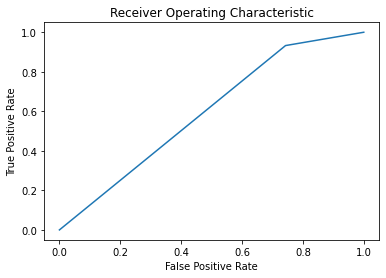

In [121]:
print_metrics(y_test,y_hypepred)

##### XGBoost

In [122]:
# Create an instance of the XGBoos
boosted_tree = XGBClassifier(random_state = 50)

# Train the model on the training data
boosted_tree.fit(X_train_tfidf, y_train)

# Predicting the values of x_train
y_boosted = boosted_tree.predict(X_test_tfidf)


[07:09:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix:
[[24094 11050]
 [ 5141 29715]]
Accuracy: 0.7687
Sensitivity: 0.8525074592609594
Specificity: 0.6855793307534714
F1 Score: 0.7858928075534574
ROC Score: 0.7690433950072154


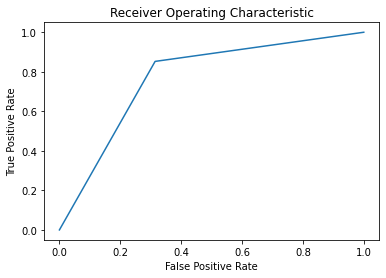

In [123]:
print_train_metrics(boosted_tree, X_train_tfidf, y_train)

Confusion Matrix:
[[ 9739  5211]
 [ 2802 12248]]
Accuracy: 0.7329
Sensitivity: 0.8138205980066445
Specificity: 0.651438127090301
F1 Score: 0.7535144113937678
ROC Score: 0.7326293625484728


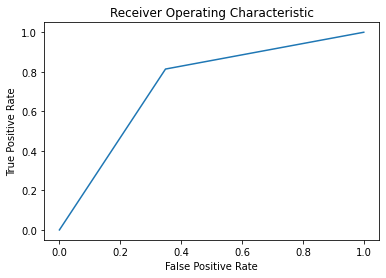

In [124]:
print_metrics(y_test,y_boosted)

##### XGBoost with hyperparameters



In [125]:
# Chosing the hyperparameters

parameters = {
    'subsample': [0.3, 0.6, 0.9],
    'learning_rate': [0.2, 0.6],
                                }

# Instanciating XGBoost model

xgboost = XGBClassifier(max_depth=2, n_estimators=200)

#Instanciating Grid search CV

xgboost_overmodel = GridSearchCV(estimator = xgboost,
                         param_grid = parameters,
                         scoring= 'roc_auc',
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         return_train_score = True)

# Fitting the model on the data

xgboost_overmodel.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[07:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [126]:
xgboost_overmodel.best_params_

{'learning_rate': 0.6, 'subsample': 0.9}

In [127]:
# Create an instance of the LogisticRegression model
boosted_hyper = XGBClassifier(learning_rate = 0.6, subsample = 0.9)

# Train the model on the training data
boosted_hyper.fit(X_train_tfidf, y_train)

# Predicting the values of x_test
y_boost = boosted_hyper.predict(X_test_tfidf)

[07:14:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix:
[[25754  9390]
 [ 5579 29277]]
Accuracy: 0.7861571428571429
Sensitivity: 0.8399414734909342
Specificity: 0.7328135670384703
F1 Score: 0.7964038464154074
ROC Score: 0.7863775202647022


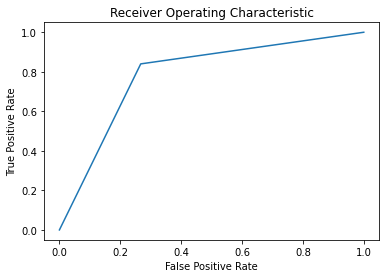

In [128]:
print_train_metrics(boosted_hyper, X_train_tfidf, y_train)

Confusion Matrix:
[[10263  4687]
 [ 3153 11897]]
Accuracy: 0.7386666666666667
Sensitivity: 0.7904983388704319
Specificity: 0.6864882943143813
F1 Score: 0.7521653916671935
ROC Score: 0.7384933165924066


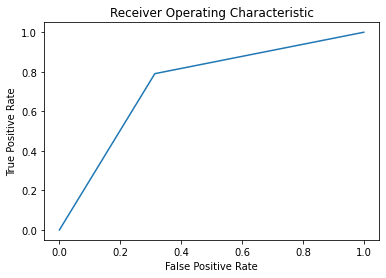

In [129]:
print_metrics(y_test,y_boost)

##### Naive Bayes

In [130]:
# Create an instance of the Naive Bayes

naive_bayes = ComplementNB()

# Train the model on the training data
naive_bayes.fit(X_train_tfidf, y_train)

# Predicting the values of x_train
y_pred_naive = naive_bayes.predict(X_test_tfidf)

Confusion Matrix:
[[29691  5453]
 [ 6910 27946]]
Accuracy: 0.8233857142857143
Sensitivity: 0.8017557952719762
Specificity: 0.8448383792396995
F1 Score: 0.8188704124239983
ROC Score: 0.8232970872558378


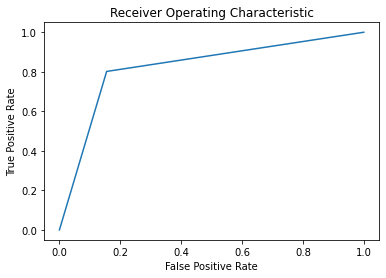

In [131]:
print_train_metrics(naive_bayes, X_train_tfidf, y_train)

Confusion Matrix:
[[11526  3424]
 [ 4234 10816]]
Accuracy: 0.7447333333333334
Sensitivity: 0.718671096345515
Specificity: 0.7709698996655518
F1 Score: 0.7385455786958005
ROC Score: 0.7448204980055335


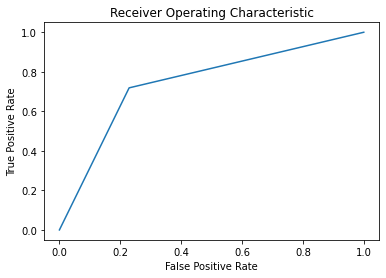

In [132]:
print_metrics(y_test,y_pred_naive)

##### Naive Bayes with Hyperparameter tuning 

In [133]:


# Chosing the hyperparameters

parameters = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'norm': [True, False],
    'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]]
}



# Instanciating Naive bayes

naive_hype = ComplementNB()

#Instanciating Grid search CV

naive_model = GridSearchCV(estimator = naive_hype,
                         param_grid = parameters,
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         return_train_score = True)

# Fitting the model on the data

naive_model.fit(X_train_tfidf,y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0],
                         'class_prior': [None, [0.1, 0.9], [0.2, 0.8],
                                         [0.3, 0.7], [0.4, 0.6], [0.5, 0.5]],
                         'norm': [True, False]},
             return_train_score=True, verbose=1)

In [134]:
naive_model.best_params_

{'alpha': 2.0, 'class_prior': None, 'norm': False}

In [135]:
# Create an instance of the Naive bayes model

hyper_naive = ComplementNB(alpha = 2.0, class_prior = None, norm = False)

# Train the model on the training data
hyper_naive.fit(X_train_tfidf, y_train)

# Predicting the values of x_train
y_naive_pred = hyper_naive.predict(X_test_tfidf)

Confusion Matrix:
[[29471  5673]
 [ 7534 27322]]
Accuracy: 0.8113285714285714
Sensitivity: 0.7838535689694744
Specificity: 0.8385784202139768
F1 Score: 0.8053529056314571
ROC Score: 0.8112159945917257


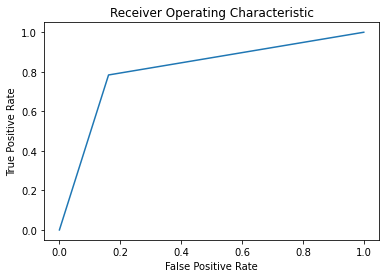

In [136]:
print_train_metrics(hyper_naive, X_train_tfidf, y_train)

Confusion Matrix:
[[11700  3250]
 [ 4269 10781]]
Accuracy: 0.7493666666666666
Sensitivity: 0.7163455149501661
Specificity: 0.782608695652174
F1 Score: 0.7414463051476908
ROC Score: 0.7494771053011701


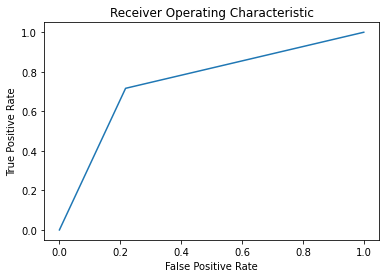

In [137]:
print_metrics(y_test,y_naive_pred)

#### Word2vec Word Embedding

Word Embeddings : They are a real-valued vector representation of words that allows words with the same meaning to have similar representation. Thus we can say word embeddings are the projection of meanings of words in a real-valued vector

Word2vec is a Word Embedding Technique published in 2013. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text.

It is the representation of words that allows words with the same meaning to have similar representation, Word2vec operationalizes this by projecting the meaning of the words in a vector space where words with similar meanings will tend to cluster together, and works with very different meanings are far from one another.

Using Pre-trained word2vec word embeddings
Training your own word embeddings is a pretty expensive process (in terms of both time and computing). Thankfully, for many scenarios, it’s not necessary to train your own embeddings Someone has done the hard work of training word embeddings on a large corpus, such as Wikipedia, news articles, or even the entire web, and has put words and their corresponding vectors on the web. These embeddings can be downloaded and used to get the vectors for the words you want.

Some of the most popular pre-trained embeddings are Word2vec by Google, GloVe by Stanford, and fasttext embeddings by Facebook, to name a few.

In [138]:

# Load pre-trained Word2Vec model
model_path = "D:\GoogleNews-vectors-negative300.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

# Generate word embeddings for each tweet
embeddings = []
for tweet in data['cleaned_text'][:100000]:
    words = tweet.split()
    emb_tweet = []
    for w in words:
        if w in model.key_to_index:
            emb_tweet.append(model.get_vector(w))
    if len(emb_tweet) > 0:
        embeddings.append(np.mean(emb_tweet, axis=0))
    else:
        embeddings.append(np.zeros(model.vector_size))



In [139]:
# Creating train test for the dataset

X_train, X_test, y_train, y_test = train_test_split(np.array(embeddings), data['label'][:100000], test_size=0.3, random_state=42)

##### Logistic regression

In [140]:

# Create an instance of the LogisticRegression model
log_model = LogisticRegression(solver = 'saga',random_state = 42,max_iter = 1000, n_jobs = -1)

# Train the model on the training data
log_model.fit(X_train, y_train)

# Predicting the values of x_train
y_pred = log_model.predict(X_test)


Confusion Matrix:
[[24602 10542]
 [ 9505 25351]]
Accuracy: 0.7136142857142858
Sensitivity: 0.7273066330043608
Specificity: 0.7000341452310493
F1 Score: 0.7166461716773381
ROC Score: 0.7136703891177052


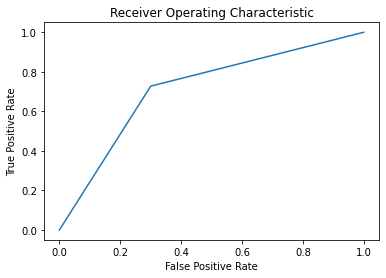

In [141]:
print_train_metrics(log_model, X_train, y_train)

Confusion Matrix:
[[10438  4512]
 [ 4190 10860]]
Accuracy: 0.7099333333333333
Sensitivity: 0.7215946843853821
Specificity: 0.6981939799331104
F1 Score: 0.7139570047991586
ROC Score: 0.7098943321592464


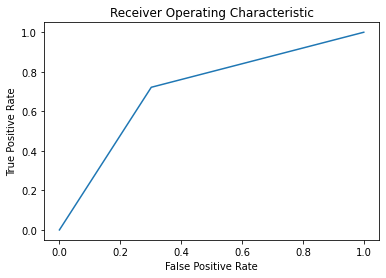

In [142]:
print_metrics(y_test,y_pred)


##### Logistic Regression with Hyperparameter tuning


In [143]:
'''Hyperparameter tuning'''
prototype = LogisticRegression(max_iter = 1000,solver = 'saga', n_jobs = -1)

parameters = [{ 'C': [0.1,0.5,1,2,5]}]

# Cross-validation
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

prototype_cv = GridSearchCV(estimator=prototype, 
                         param_grid =parameters,
                         scoring= 'roc_auc',
                         cv=folds, 
                         return_train_score=True,
                         n_jobs=-1,
                         verbose=1)

prototype_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                          solver='saga'),
             n_jobs=-1, param_grid=[{'C': [0.1, 0.5, 1, 2, 5]}],
             return_train_score=True, scoring='roc_auc', verbose=1)

In [144]:
prototype_cv.best_params_

{'C': 0.5}

In [145]:

# Create an instance of the LogisticRegression model
log_hypemodel = LogisticRegression(random_state = 1000,C = 0.5,n_jobs=-1,max_iter = 1000)

# Train the model on the training data
log_hypemodel.fit(X_train, y_train)

# Predicting the values of x_train
y_pred = log_hypemodel.predict(X_test)



Confusion Matrix:
[[24603 10541]
 [ 9522 25334]]
Accuracy: 0.7133857142857143
Sensitivity: 0.7268189120954786
Specificity: 0.7000625995902572
F1 Score: 0.7163478531337037
ROC Score: 0.7134407558428678


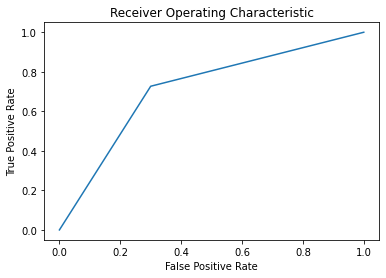

In [146]:
print_train_metrics(log_hypemodel, X_train, y_train)

Confusion Matrix:
[[10446  4504]
 [ 4178 10872]]
Accuracy: 0.7106
Sensitivity: 0.7223920265780731
Specificity: 0.6987290969899665
F1 Score: 0.7146519424176692
ROC Score: 0.7105605617840198


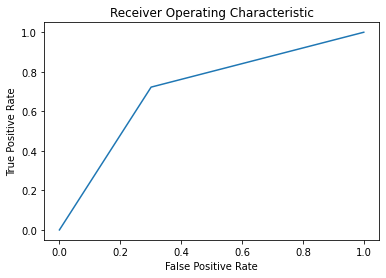

In [147]:
print_metrics(y_test,y_pred)

##### Decision Treee Classifier 

In [148]:

# Create an instance of the Decision tree  model
tree = DecisionTreeClassifier(random_state = 100, max_features='sqrt')

# Train the model on the training data
tree.fit(X_train, y_train)

# Predicting the values of x_train
y_treepred = tree.predict(X_test)

Confusion Matrix:
[[34461   683]
 [  452 34404]]
Accuracy: 0.9837857142857143
Sensitivity: 0.9870323617167776
Specificity: 0.9805656726610517
F1 Score: 0.983772500464664
ROC Score: 0.9837990171889146


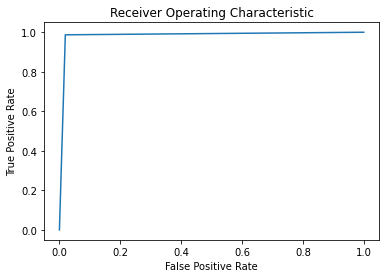

In [149]:
print_train_metrics(tree, X_train, y_train)

Confusion Matrix:
[[8727 6223]
 [6252 8798]]
Accuracy: 0.5841666666666666
Sensitivity: 0.5845847176079734
Specificity: 0.5837458193979933
F1 Score: 0.5851484819261081
ROC Score: 0.5841652685029833


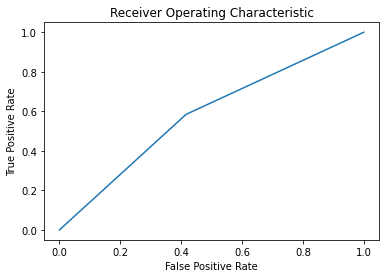

In [150]:
print_metrics(y_test,y_treepred)

##### Decision tree with hyperparameter 


In [151]:
# Choosing the hyperparameters

parameters = {
    'min_samples_leaf' : range(50,500,50),
    'min_samples_split' : range(50,500,50),
    'max_depth' : range(5,15,5)
   
}


# Instanciating Decision Tree

tree = DecisionTreeClassifier(random_state = 42,max_features='sqrt')

#Instanciating Grid search CV

model_tree = GridSearchCV(estimator = tree,
                         param_grid = parameters,
                         scoring= 'roc_auc',
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         )

# Fitting the model on the data

model_tree.fit(X_train,y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_features='sqrt',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 500, 50),
                         'min_samples_split': range(50, 500, 50)},
             scoring='roc_auc', verbose=1)

In [152]:
model_tree.best_params_

{'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 350}

In [153]:

# Create an instance of the LogisticRegression model
hyper_tree = DecisionTreeClassifier(min_samples_split = 450, min_samples_leaf = 100, max_depth = 10,random_state = 49)

# Train the model on the training data
hyper_tree.fit(X_train, y_train)

# Predicting the values of x_train
y_hypepred = hyper_tree.predict(X_test)

Confusion Matrix:
[[23487 11657]
 [11660 23196]]
Accuracy: 0.6669
Sensitivity: 0.6654808354372275
Specificity: 0.6683075347143183
F1 Score: 0.6655094751036451
ROC Score: 0.6668941850757729


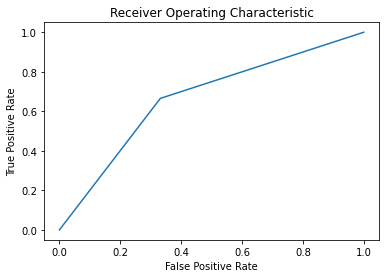

In [154]:
print_train_metrics(hyper_tree, X_train, y_train)

Confusion Matrix:
[[9362 5588]
 [5686 9364]]
Accuracy: 0.6242
Sensitivity: 0.6221926910299004
Specificity: 0.6262207357859532
F1 Score: 0.6242250516632225
ROC Score: 0.6242067134079268


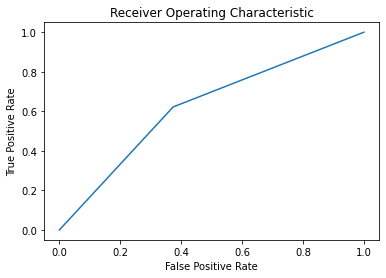

In [155]:
print_metrics(y_test,y_hypepred)

##### XGBoost

In [156]:
# Create an instance of the XGBoos
boosted_tree = XGBClassifier(random_state = 50)

# Train the model on the training data
boosted_tree.fit(X_train, y_train)

# Predicting the values of x_train
y_boosted = boosted_tree.predict(X_test)


[07:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix:
[[30831  4313]
 [ 4045 30811]]
Accuracy: 0.8806
Sensitivity: 0.8839511131512509
Specificity: 0.8772763487366264
F1 Score: 0.8805658759645614
ROC Score: 0.8806137309439386


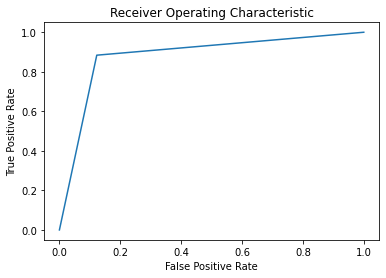

In [157]:
print_train_metrics(boosted_tree, X_train, y_train)

Confusion Matrix:
[[10441  4509]
 [ 4409 10641]]
Accuracy: 0.7027333333333333
Sensitivity: 0.7070431893687708
Specificity: 0.6983946488294315
F1 Score: 0.7047019867549669
ROC Score: 0.7027189190991012


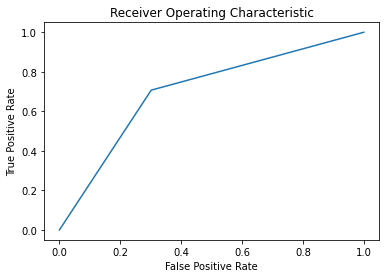

In [158]:
print_metrics(y_test,y_boosted)

##### XGBoost with hyperparameters



In [159]:
# Chosing the hyperparameters

parameters = {
    'subsample': [0.3, 0.6, 0.9],
    'learning_rate': [0.2, 0.6],
                                }

# Instanciating XGBoost model

xgboost = XGBClassifier(max_depth=2, n_estimators=200)

#Instanciating Grid search CV

xgboost_overmodel = GridSearchCV(estimator = xgboost,
                         param_grid = parameters,
                         scoring= 'roc_auc',
                         cv = 3,
                         n_jobs = -1,
                         verbose = 1,
                         return_train_score = True)

# Fitting the model on the data

xgboost_overmodel.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[07:31:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [160]:
xgboost_overmodel.best_params_

{'learning_rate': 0.2, 'subsample': 0.6}

In [161]:
# Create an instance of the LogisticRegression model
boosted_hyper = XGBClassifier(learning_rate = 0.2, subsample = 0.9)

# Train the model on the training data
boosted_hyper.fit(X_train, y_train)

# Predicting the values of x_testb
y_boost = boosted_hyper.predict(X_test)

[07:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Confusion Matrix:
[[29694  5450]
 [ 5062 29794]]
Accuracy: 0.8498285714285714
Sensitivity: 0.8547739270140005
Specificity: 0.844923742317323
F1 Score: 0.8500427960057062
ROC Score: 0.8498488346656617


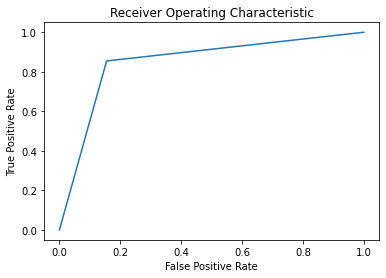

In [162]:
print_train_metrics(boosted_hyper, X_train, y_train)

Confusion Matrix:
[[10484  4466]
 [ 4284 10766]]
Accuracy: 0.7083333333333334
Sensitivity: 0.7153488372093023
Specificity: 0.7012709030100335
F1 Score: 0.7110494683310218
ROC Score: 0.708309870109668


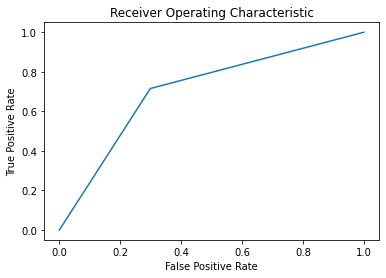

In [163]:
print_metrics(y_test,y_boost)